### Data Explanation ###

To build a model we are going to use a LSTM. Dataset we are going to use was "modeldf.csv". We need to transform this dataset in a way as input and output. 

For example, if we are going to train a model to predict next 5 days demand, then first 25 days are used as a training set and last 5 days traffic as an output. In our case,  we are just considering 2 months of data so first we will define a window length(n) and output will be(n+1) element. 

ie.., For example we have raw data=[10,20,30,40,50,60] and n=3 then we are going to split the data in a way

Input, output
<br/>
[10,20,30], [40]
<br/>
[20,30,40], [50]
<br/>
[30,40,50], [60]

it's basically just a 1 sliding window data. In our case, we will follow the same structure to train a model and evaluate its prediction

In [1]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("modeldf.csv", sep=",")
df.shape

(21190, 4)

In [7]:
#data description
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21190 entries, 0 to 21189
Data columns (total 4 columns):
Start_Time      21190 non-null object
Stop_Time       21190 non-null object
N_Bikes         21190 non-null int64
Station_Name    21190 non-null object
dtypes: int64(1), object(3)
memory usage: 662.3+ KB


In [8]:
df.head()

,Start_Time,Stop_Time,N_Bikes,Station_Name
0,2017-01-01 T00:00 Z,2017-01-01 T00:20 Z,0,Pershing Square North
1,2017-01-01 T00:20 Z,2017-01-01 T00:40 Z,0,Pershing Square North
2,2017-01-01 T00:40 Z,2017-01-01 T01:00 Z,1,Pershing Square North
3,2017-01-01 T01:00 Z,2017-01-01 T01:20 Z,0,Pershing Square North
4,2017-01-01 T01:20 Z,2017-01-01 T01:40 Z,0,Pershing Square North


### Data Preparation ###

In our case, we need to train a model per station. Because, we need to predict the demand per station.

In [27]:
#window length of size 10 and element at 11 act as a output
n_steps=10

def split_dataset(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        #find the end of this pattern
        end = i + n_steps
        #check if we are beyong the sequence
        if end > len(sequence)-1:
            break
        #gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end], [sequence[end]]
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

inp_seq, output = split_dataset(df['N_Bikes'], n_steps)

In [28]:
inp_seq

array([[ 0,  0,  1, ...,  0,  0,  0],
       [ 0,  1,  0, ...,  0,  0,  1],
       [ 1,  0,  0, ...,  0,  1,  0],
       ...,
       [ 4,  9, 11, ..., 10,  6,  7],
       [ 9, 11, 10, ...,  6,  7,  2],
       [11, 10,  8, ...,  7,  2,  8]])

In [29]:
output

array([[1],
       [0],
       [0],
       ...,
       [2],
       [8],
       [5]])

### Split the dataset into Train and Eval ###

In [44]:
def split_train_eval(input_seq, output_seq, percentage=None):
    #get the length of the dataset
    N = len(input_seq)
    #split the percentage
    eval_len = int(N * 20 / 100)
    #trainset, evalset
    train_inp, train_out = input_seq[:-eval_len], output_seq[:-eval_len]
    eval_inp, eval_out = input_seq[-eval_len:], output_seq[-eval_len:]
    
    return train_inp, train_out, eval_inp, eval_out
    
train_x, train_y, eval_x, eval_y= split_train_eval(inp_seq, output, 10)
print("DataFrame shape")
print("Train DataFrame Shape:{},{}".format(train_x.shape, train_y.shape))
print("Eval DataFrame Shape:{},{}".format(eval_x.shape, eval_y.shape))

DataFrame shape
Train DataFrame Shape:(16944, 10),(16944, 1)
Eval DataFrame Shape:(4236, 10),(4236, 1)


In [45]:
def save_dataset(path, numpy_array):
    
    if numpy_array is None or len(numpy_array)==0 or len(numpy_array[0])==0:
        savedf = False
    else:
        savedf = True
        fileobj = pd.DataFrame(numpy_array[0:, 0:],
                              index=[i for i in range(numpy_array.shape[0])], 
                              columns=['f'+str(i) for i in range(numpy_array.shape[1])])
    
    if savedf:
        fileobj.to_csv(path, sep=",", index=False)

save_dataset("model_dataset/train_input.csv", train_x)
save_dataset("model_dataset/train_output.csv", train_y)

save_dataset("model_dataset/eval_input.csv", eval_x)
save_dataset("model_dataset/eval_output.csv", eval_y)

### Model Training ###

In [38]:
#starting with simple Keras Wrapper
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

n_features=1 #output
n_output = 1
def network():
    model = Sequential()
    model.add(LSTM(10, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(n_output))
    model.compile(loss='mse', optimizer='adam')
    
    return model

model_arch = network()

Instructions for updating:
Colocations handled automatically by placer.


In [40]:
model_arch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


In [46]:
#model params
epochs=100
bs=8
verbose=1

#before fitting the model, we need to transform
#the shape of the train_input and eval_input
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
eval_x = eval_x.reshape((eval_x.shape[0], eval_x.shape[1], n_features))

#fit the model
model_arch.fit(train_x, train_y, epochs=epochs, verbose=verbose)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
16944/16944 [==============================] - 7s 394us/step - loss: 16.0377
Epoch 2/100
16944/16944 [==============================] - 6s 341us/step - loss: 7.1049
Epoch 3/100
16944/16944 [==============================] - 6s 359us/step - loss: 6.7397
Epoch 4/100
16944/16944 [==============================] - 6s 367us/step - loss: 6.5284
Epoch 5/100
16944/16944 [==============================] - 6s 345us/step - loss: 6.3918
Epoch 6/100
16944/16944 [==============================] - 6s 350us/step - loss: 6.3839
Epoch 7/100
16944/16944 [==============================] - 6s 348us/step - loss: 6.3148
Epoch 8/100
16944/16944 [==============================] - 6s 349us/step - loss: 6.3529
Epoch 9/100
16944/16944 [==============================] - 6s 350us/step - loss: 6.3561
Epoch 10/100
16944/16944 [==============================] - 6s 352us/step - loss: 6.3951
Epoch 11/100
16944/16944 [==============================] - 6s 370us/s

16944/16944 [==============================] - 6s 358us/step - loss: 5.9191
Epoch 91/100
16944/16944 [==============================] - 6s 359us/step - loss: 5.9395
Epoch 92/100
16944/16944 [==============================] - 6s 359us/step - loss: 6.0612
Epoch 93/100
16944/16944 [==============================] - 6s 359us/step - loss: 5.9157
Epoch 94/100
16944/16944 [==============================] - 6s 354us/step - loss: 5.7530
Epoch 95/100
16944/16944 [==============================] - 6s 356us/step - loss: 5.8393
Epoch 96/100
16944/16944 [==============================] - 6s 346us/step - loss: 5.7624
Epoch 97/100
16944/16944 [==============================] - 6s 341us/step - loss: 6.0835
Epoch 98/100
16944/16944 [==============================] - 6s 351us/step - loss: 5.7744
Epoch 99/100
16944/16944 [==============================] - 6s 348us/step - loss: 5.7924
Epoch 100/100
16944/16944 [==============================] - 6s 343us/step - loss: 5.7919


In [47]:
y_hat = model_arch.predict(eval_x, verbose=1)

4236/4236 [==============================] - 1s 129us/step


In [77]:
def convert_to_df(actual_data, predicted_data):
    act, pred=[], []
    
    for x in actual_data:
        act.append(x[0])

    for y in predicted_data:
        pred.append(y[0])
    
    performance_df = pd.DataFrame({'actual':act, 'prediction':pred})
    
    return performance_df

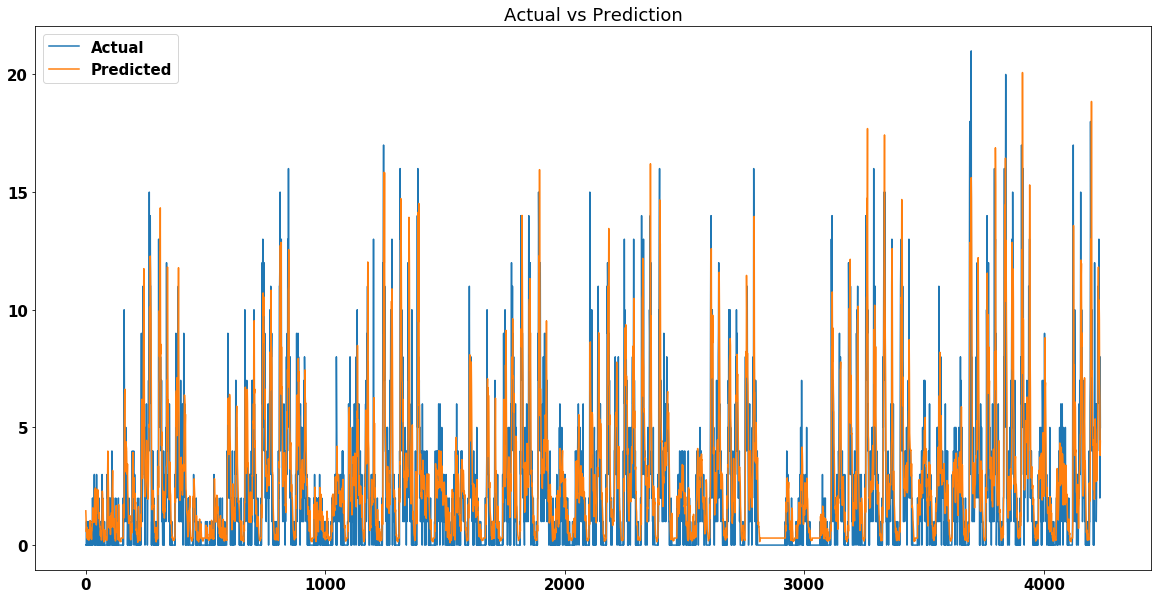

In [87]:
#plot the model performance
import matplotlib.pyplot as plt
import seaborn as sns

#setting figure size for whole notebook
%matplotlib inline
font = {
    'family':'normal',
    'weight':'bold',
    'size':15
}

plt.rcParams["figure.figsize"] = [20, 10]
plt.rc('font', **font)

performance_df = convert_to_df(eval_y, y_hat)

def plot_line(plot_df, filename=None):
    fig, ax = plt.subplots()

    ax.plot(plot_df['actual'], label='Actual')
    ax.plot(plot_df['prediction'], label='Predicted')

    plt.title("Actual vs Prediction")
    plt.legend(loc='upper left')
    plt.savefig(filename)
    plt.show()

plot_line(performance_df, 'performance_image/performance_allstock.jpg')

In [81]:
#mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(performance_df['actual'], performance_df['prediction'])
print("mean squared error:{}".format(mse))

mean squared error:5.591870261201549


In [68]:
#save model
model_arch.save("model_trained_in_whole_station_data.h5")

### Observation ###

The above model was trained in whole data without any specific station. But in real time, we need to train a same model per station to predict what will be the  demand at specific time at this station.

### Model Training on Pershing Square North ###

In [69]:
pershing_square_north = df[df['Station_Name'] == 'Pershing Square North']
pershing_square_north.shape

(4238, 4)

In [72]:
psn_x, psn_y = split_dataset(pershing_square_north['N_Bikes'], 10)

print("Pershing Square North DataFrame Shape")
print(psn_x.shape, psn_y.shape)

Pershing Square North DataFrame Shape
(4228, 10) (4228, 1)


In [73]:
train_psn_inp, train_psn_out, eval_psn_train, eval_psn_out = split_train_eval(psn_x, psn_y, 5)

print("Train and Eval Shape")
print(train_psn_inp.shape, train_psn_out.shape, eval_psn_train.shape, eval_psn_out.shape)

Train and Eval Shape
(3383, 10) (3383, 1) (845, 10) (845, 1)


In [74]:
psn_model = network()

#model params
epochs=50
bs=8
verbose=1

train_psn_inp = train_psn_inp.reshape((train_psn_inp.shape[0], train_psn_inp.shape[1], n_features))
eval_psn_train = eval_psn_train.reshape((eval_psn_train.shape[0], eval_psn_train.shape[1], n_features))

In [75]:
#fit the model
psn_model.fit(train_psn_inp, train_psn_out, epochs=epochs, verbose=verbose)

Epoch 1/50
3383/3383 [==============================] - 2s 637us/step - loss: 41.4926
Epoch 2/50
3383/3383 [==============================] - 1s 377us/step - loss: 15.0875
Epoch 3/50
3383/3383 [==============================] - 1s 354us/step - loss: 12.3864
Epoch 4/50
3383/3383 [==============================] - 1s 367us/step - loss: 11.4637
Epoch 5/50
3383/3383 [==============================] - 1s 372us/step - loss: 11.0087
Epoch 6/50
3383/3383 [==============================] - 1s 403us/step - loss: 10.7390
Epoch 7/50
3383/3383 [==============================] - 1s 345us/step - loss: 10.4864
Epoch 8/50
3383/3383 [==============================] - 1s 364us/step - loss: 10.3568
Epoch 9/50
3383/3383 [==============================] - 1s 362us/step - loss: 10.0081
Epoch 10/50
3383/3383 [==============================] - 1s 352us/step - loss: 10.2007
Epoch 11/50
3383/3383 [==============================] - 1s 367us/step - loss: 9.9484
Epoch 12/50
3383/3383 [==============================

In [76]:
psn_y_hat = psn_model.predict(eval_psn_train, verbose=1)

845/845 [==============================] - 0s 326us/step


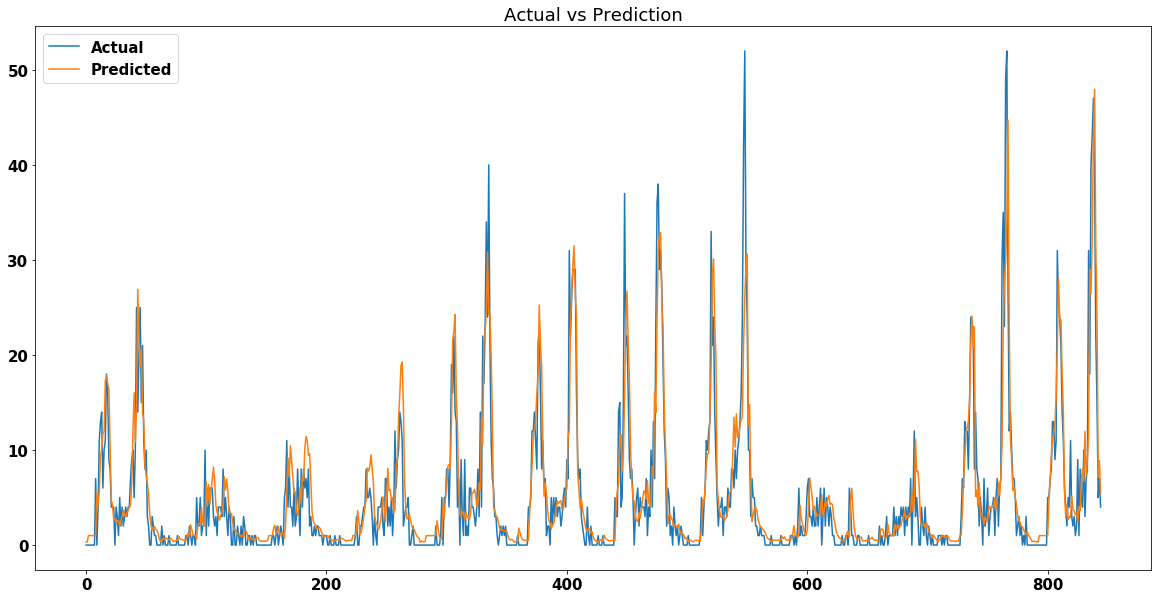

In [89]:
psn_performance = convert_to_df(eval_psn_out, psn_y_hat)
plot_line(psn_performance, "performance_image/performance_on_psn_station.jpg")

In [100]:
from sklearn.metrics import mean_absolute_error


def mape(act, pred):
    mask = act != 0
    return (np.fabs((act - pred))/act)[mask].mean()

psn_mse = mean_squared_error(psn_performance['actual'], psn_performance['prediction'])
print("mean squared error:{}".format(psn_mse))

psn_mape = mape(psn_performance['actual'], psn_performance['prediction'])
print("mean absolute error:{}".format(psn_mape))

mean squared error:14.764243220776793
mean absolute error:0.6458381108921512
